In [11]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u


plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def crosscorr_mat(trial_mat, inds = np.arange(-29,29)):
    inds = np.arange(-29,30)
    cc_mat = np.nan*np.zeros([trial_mat.shape[0], trial_mat.shape[0], inds.shape[0]])
    for cell in range(trial_mat.shape[-1]):
        for trial0 in range(trial_mat.shape[0]):
            for trial1 in range(trial_mat.shape[0]):
                tmp = np.correlate(trial_mat[trial0,:,cell],trial_mat[trial1,:,cell],mode='full')
#                 if np.amax(tmp)>.2:
                cc_mat[trial0,trial1,:] += tmp
    
    return cc_mat/trial_mat.shape[-1], inds

def pv_crosscorr(trial_mat):
    
    tm_z = sp.stats.zscore(trial_mat, axis=-1)

    n_trials, n_pos, n_cells = trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[-1]  
    cc_mat = np.zeros((n_trials, n_trials, 2*n_pos-1))
    for t,tp in product(range(n_trials), range(n_trials)):

        _z_t, _z_tp = tm_z[t,:,:], tm_z[tp,:,:]
        z_t, z_tp = np.zeros((n_pos*3-2,n_cells)), _z_tp[:,:]
        z_t[n_pos-1:2*n_pos-1,:] = _z_t
        for shift in range(0, 2*n_pos-1):
            cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)

    return cc_mat

# def crosscorr_res(sess):
#     trial_mat = sp.ndimage.filters.gaussian_filter1d(sess.trial_matrices['spks_norm'][:,:,:],1,axis=1)
#     trial_mat[np.isnan(trial_mat)]=1E-5
    
#     cc_mat = pv_crosscorr(trial_mat)
    
#     return {'cc_mat': cc_mat,
#             'trial_info': sess.trial_info,
#             'speed': np.nanmean(sess.trial_matrices['speed'], axis=1)
#            }    

def cc_com(cc_mat, inds = np.arange(-29,30)):
    return np.nansum(cc_mat*inds[np.newaxis,np.newaxis,:], axis=-1)/(np.nansum(cc_mat,axis=-1)+1E-3)

shift = lambda com: com*(np.tril(-1*np.ones(com.shape),k=-1) + np.triu(np.ones(com.shape), k=1))

def run_crosscorr(sess, nov=True, max_trial = 5, arm_only = False, smooth = 0, keyname = 'spks_norm', cre=True):
    if nov:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
    else:
        trial_mask = (-1*sess.trial_info['LR']==sess.novel_arm) & (sess.trial_info['block_number']==5)
                  
    com = np.nan*np.zeros([max_trial,max_trial])
    if arm_only:
#         trial_mat = sess.trial_matrices['spks_norm'][trial_mask,:,:][:max_trial,12:,:]
        if cre:
            trial_mat = sess.mcherry_pos_trialmatrix(keyname)[trial_mask,:,:][:max_trial,12:,:]
        else:
            trial_mat = sess.mcherry_neg_trialmatrix(keyname)[trial_mask,:,:][:max_trial,12:,:]
    else:
        if cre:
            trial_mat = sess.mcherry_pos_trialmatrix(keyname)[trial_mask,:,:][:max_trial,:,:]
        else:
            trial_mat = sess.mcherry_neg_trialmatrix(keyname)[trial_mask,:,:][:max_trial,:,:]
        
    trial_mat[np.isnan(trial_mat)]=1E-3
        
    if smooth>0:
        if arm_only:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,12:,:]
        else:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]
        
    
    speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:,][:max_trial,:])
    cc_mat = pv_crosscorr(trial_mat)
    
    
    
    com[:trial_mat.shape[0], :trial_mat.shape[0]] = cc_com(cc_mat, inds = np.arange(-trial_mat.shape[1]+1,trial_mat.shape[1]))
    return {'cc_mat': cc_mat,
           'com': com,
           'shift': np.nanmean(shift(com)),
           'speed': speed}

In [12]:
sess = u.load_single_day('Cre7',0,pkl_basedir="/home/mplitt/YMazeSessPkls/HandCurated")

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [13]:
cre_res = run_crosscorr(sess,nov=True,cre=True,max_trial=20,keyname='F_dff')

/tmp/ipykernel_2190293/2655061286.py:25: RuntimeWarning: Mean of empty slice
  cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)


In [14]:
notcre_res = run_crosscorr(sess,nov=True,cre=False,max_trial=20,keyname='spks_norm')

/tmp/ipykernel_2190293/2655061286.py:25: RuntimeWarning: Mean of empty slice
  cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)


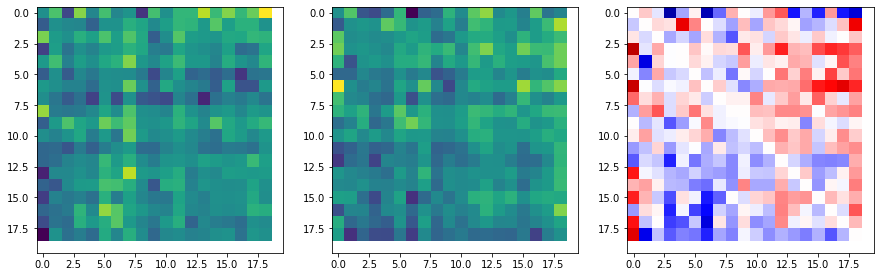

In [15]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
ax[0].imshow(cre_res['com'])
ax[1].imshow(notcre_res['com'])
ax[2].imshow(notcre_res['com']-cre_res['com'], cmap='seismic', vmin=-10,vmax=10)